In [267]:
#importation des modules
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import requests  # Connexion à l'API de AlphaVantage

In [299]:
#entrée des données
# Clé personnelle de l'API AlphaVantage
key_API = 'LYMJQ6KR5QPKJ8W3'
rate = 'FEDERAL_FUNDS_RATE'   # Choisissez n'importe quel taux
url = f'https://www.alphavantage.co/query?function={rate}&interval=monthly&apikey={key_API}'
r = requests.get(url)
data = r.json()
# Accédez à la clé 'data' dans le dictionnaire
data = data['data']

# Créez un tableau NumPy contenant toutes les valeurs
values = np.array([float(entry['value']) for entry in data])

In [300]:
# On suppose une volatilité constante (très faux)
ecart_type = np.std(values/100)
v = ecart_type * np.sqrt(12)
print(v)

0.12458611815655554


Le modèle de Vasicek est approprié à une évaluation sur le court terme, on va donc récupérer uniquement les 100 dernièrs mois du jeu de données.

In [282]:
# Traitement des données 
data_ = values [731:]
X_train = data_ [:100]
X_test = data_ [50:]

**Modèle de Vasicek :**

$$drt = a(k - rt)dt + \sigma dW(t)$$

$$r_{t + \delta} = r_t e^{-a\delta} + k(1 - e^{-a\delta}) + \frac{\sigma}{\sqrt{2a}}\varepsilon, \quad \varepsilon \sim \mathcal{N}(0, 1)$$



In [283]:
#loi normale que suit le taux dans le modèle de vasicek

def N_(x,a,k,t,r0):
    var=np.sqrt((np.square(v)/2*a))
    esp=r0*np.exp(-a*t)+k*(1-np.exp(-a*t))
    return ((1/(var*np.sqrt(2*np.pi)))*np.exp(-0.5*np.square((x-esp)/var)))

**Fonction de Vraisemblance :** (formule cas discret)
$$L(a, k) = P(X_1 = x_1) \cdot P(X_2 = x_2 \,|\, X_1 = x_1) \cdot \ldots \cdot P(X_n = x_n \,|\, X_{n-1} = x_{n-1})$$

**Fonction de log-Vraisemblance :**
$$\ln(L(a, k)) = \ln(P(X_1 = x_1)) + \ln(P(X_2 = x_2 | X_1 = x_1)) + \ldots + \ln(P(X_n = x_n | X_{n-1} = x_{n-1}))$$


In [284]:
#définissons maintenant la fonction de log vraisemblance

def log_vraisemblance(paramètres, X_train):
    a, k = paramètres
    S=0
    t=1/12
    for i in range (len(X_train)-1):
        P = N_(X_train[i+1], a, k, t, X_train[i])
        S-=np.log(P)
    return(S)

In [285]:
# Estimation des paramètres avec la méthode MLE
# Contraintes
constraints = ({'type': 'ineq', 'fun': lambda params: params[0]},  # a >= 0
               {'type': 'ineq', 'fun': lambda params: params[1]})  # k >= 0

resultat_estimation = minimize(log_vraisemblance, [5, 1], X_train, constraints=constraints)
parametres_estimes = resultat_estimation.x

/var/folders/28/1h3z3mcs1gxg23mnjw1zj_n00000gn/T/ipykernel_14516/952324210.py:4: RuntimeWarning: invalid value encountered in sqrt
  var=np.sqrt((np.square(v)/2*a))
/var/folders/28/1h3z3mcs1gxg23mnjw1zj_n00000gn/T/ipykernel_14516/2276258991.py:9: RuntimeWarning: divide by zero encountered in log
  S-=np.log(P)


In [286]:
# Affichage des paramètres estimés
a_estime, k_estime = parametres_estimes
print("Paramètre a estimé : ", a_estime)
print("Paramètre k estimé : ", k_estime)

Paramètre a estimé :  5.180864046221867
Paramètre k estimé :  2.402927913944615


In [297]:
#simulations de taux aléatoire 
A = []
B = []
C = []
t = 1/12

for k in range (len(X_test)):
    var=np.sqrt((np.square(v)/(2*a_estime)))
    esp=X_test[k-1]*np.exp(-a_estime*t)+k_estime*(1-np.exp(-a_estime*t))

    tirage = np.random.normal(0, 1, 3)
    A.append(esp + var*tirage[0])
    B.append(esp + var*tirage[1])
    C.append(esp + var*tirage[2])


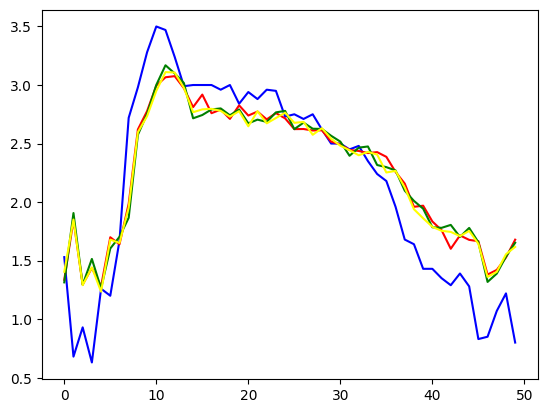

In [298]:
# Visualisation
abscisse=[i for i in range(len(X_test))]
plt.plot(abscisse, X_test, label='Données réelles', color='blue')
plt.plot(abscisse, A, label='Simulation 1', color='red')
plt.plot(abscisse, B, label='Simulation 2', color='green')
plt.plot(abscisse, C, label='Simulation 3', color='yellow')

**En conclusion :**

On remarque que la forme générale de la courbe des taux est respectée dans les trois simulations. Cependant, il est important de noter quelques irrégularités, notamment au début de la courbe. Ces irrégularités peuvent être attribuées au fait que le modèle de Vasicek est principalement conçu pour modéliser les taux à court terme. En effet le modèle de Vasicek présente une force de rappel vers k, au début de la courbe, le taux a une valeur clairement inférieure à k ce qui explique que la courbe monte au lieu de descendre.

Les données que j'ai utilisées sont échantillonnées de manière mensuelle, ce qui peut ne pas être idéal pour ce modèle, et la période sur laquelle les données s'étendent est peut-être trop longue pour une adaptation optimale du modèle.

**Conclusion (english version) :**

We notice that the general shape of the yield curve is maintained in all three simulations. However, it's important to note some irregularities, especially at the beginning of the curve. These irregularities can be attributed to the fact that the Vasicek model is primarily designed to model short-term interest rates. Indeed, the Vasicek model has a mean-reverting feature towards k, and at the beginning of the curve, the rate is clearly below k, which explains why the curve rises instead of declining.

The data I used is sampled on a monthly basis, which may not be ideal for this model, and the period over which the data extends may be too long for optimal model adaptation.